In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score
from scipy.stats import kstest, mannwhitneyu
from scipy.stats import ks_2samp
import itertools
# import shap

from tqdm import tqdm

import matplotlib.pyplot as plt
import pingouin as pg
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

met_file_path = "C:/Users/shrra/Downloads/merged_n586_Alasdair_May21_concatenated_renamed.csv"
met1_df = pd.read_csv(met_file_path)
# print(met1_df.columns)


In [3]:
met1_df_T  = met1_df.T

In [4]:


met1_df_T.reset_index(inplace=True)

# Set the first row as the header
met1_df_T.columns = met1_df_T.iloc[0]
met1_df_T = met1_df_T[1:]

# Reset the index again (if you want to have a clean numeric index)
met1_df_T.reset_index(drop=True, inplace=True)

# Rename the newly created index column (if needed)
met1_df_T.rename(columns={met1_df_T.columns[0]: 'ID'}, inplace=True)


# print(met1_df_T.columns)


In [5]:
met1_df_T['ID'] = met1_df_T['ID'].str.replace('-S.*', '', regex=True)
# print(len(met1_df_T))
# print(met1_df_T.columns)


In [6]:
mas_file_path = "C:/Users/shrra/Downloads/MASH_biomarkers_clinicaldata_notimputed_May30_HH.csv"
mash_df = pd.read_csv(mas_file_path)
mash_df['MASH'] = mash_df['MASH'].map({'MASH': 1, 'non-MASH': 0})
# print(mash_df.columns)


In [7]:
id_df = mash_df[['ID', 'MASH']]


In [8]:
id_df['ID'] = id_df['ID'].str.replace('5-00', '')
id_df['ID'] = id_df['ID'].str.replace('5-0', '')

C:\Users\shrra\AppData\Local\Temp\ipykernel_8672\3199667862.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  id_df['ID'] = id_df['ID'].str.replace('5-00', '')
C:\Users\shrra\AppData\Local\Temp\ipykernel_8672\3199667862.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  id_df['ID'] = id_df['ID'].str.replace('5-0', '')


In [9]:
df1 = id_df[['ID']]
df2 = met1_df_T[['ID']]


set1 = set(df1['ID'])
set2 = set(df2['ID'])

# Find values in df1['ID'] that are not in df2['ID']
missing_in_df2 = set1 - set2

# Find values in df2['ID'] that are not in df1['ID']
missing_in_df1 = set2 - set1

# # Display the missing values
# print("\nID Values in mash file that are not in metab file")
# print(missing_in_df2)
# print(len(missing_in_df2))
# print("\nID Values in metab file that are not in mash file")
# print(missing_in_df1)
# print(len(missing_in_df1))

In [10]:
Updated_meta_df = pd.merge(id_df, met1_df_T, on=['ID'], how='inner')

In [11]:
KSTest_df = Updated_meta_df


excluded_cols = ["ID"]
KSTest_df= KSTest_df.drop(columns=excluded_cols)

In [12]:
import pandas as pd
from scipy.stats import ks_2samp

# Assuming KSTest_df is your DataFrame
target_column = 'MASH'

# Calculate p-values for each feature in advance and store in a dictionary
p_values_dict = {}
for feature in KSTest_df.columns:
    if feature != target_column:
        Controls = KSTest_df[KSTest_df[target_column] == 0][feature].dropna()
        MASH = KSTest_df[KSTest_df[target_column] == 1][feature].dropna()

        # Ensure the columns are numeric
        Controls = pd.to_numeric(Controls, errors='coerce')
        MASH = pd.to_numeric(MASH, errors='coerce')

        _, KS_p_value = ks_2samp(Controls, MASH)
        p_values_dict[feature] = KS_p_value

# Convert the dictionary to a DataFrame for better visualization
ranking_df = pd.DataFrame(list(p_values_dict.items()), columns=['feature', 'KS p-value'])

# Print the p-values DataFrame
# print("\nP-Values DataFrame:\n", ranking_df)

# Calculate correlation matrix
corr_matrix = KSTest_df.drop(target_column, axis=1).corr().abs()

# Set threshold for high correlation
corr_threshold_low = 0.5

# Dictionary to store highly correlated features for each feature
highly_correlated_features = {}

# Loop through the features and find highly correlated features
for feature in corr_matrix.columns:
    highly_corr = corr_matrix[(corr_matrix[feature] > corr_threshold_low)][feature].index.tolist()
    if highly_corr:
        highly_correlated_features[feature] = highly_corr

# Perform KS test for each group and keep the feature with the best p-value
selected_features = set()
ks_test_results = {}

# DataFrame to store selected features and their p-values
selected_features_df = pd.DataFrame(columns=['Group', 'Selected_Feature', 'p-value'])

# Set to keep track of already selected features
excluded_features = set()

for feature, correlated in highly_correlated_features.items():
    # Filter out already selected features
    candidates = [col for col in correlated + [feature] if col not in excluded_features]
    if not candidates:
        continue
    # Use precomputed p-values from the dictionary
    p_values = {col: p_values_dict[col] for col in candidates}
    ks_test_results[feature] = p_values
    best_feature = min(p_values, key=p_values.get)
    selected_features.add(best_feature)
    excluded_features.update(candidates)
    
    # Add the selected feature and its p-value to the DataFrame
    new_row = pd.DataFrame({'Group': [feature], 'Selected_Feature': [best_feature], 'p-value': [p_values[best_feature]]})
    selected_features_df = pd.concat([selected_features_df, new_row], ignore_index=True)

# Final set of features
final_selected_features = list(selected_features)

# Display the DataFrame of selected features and their p-values
# print("\nThis df has Selected Features and Their p-values:\n", selected_features_df)


C:\Users\shrra\AppData\Local\Temp\ipykernel_8672\2698131470.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  selected_features_df = pd.concat([selected_features_df, new_row], ignore_index=True)


In [13]:
print(len(final_selected_features))
check = set(final_selected_features)
print("So unique would be")
print(len(check))

2278
So unique would be
2278


In [14]:
import pandas as pd

# Assuming selected_features_df is your original DataFrame
threshold = 0.05 / 3759

# Initialize count and a list to store the rows that meet the criteria
count = 0
filtered_rows = []

# Iterate over the rows in the DataFrame
for index, row in selected_features_df.iterrows():
    if row['p-value'] < threshold:
        count += 1
        filtered_rows.append(row)

# Create a new DataFrame from the filtered rows
Pvalue_cutoff_df = pd.DataFrame(filtered_rows)

print("number of features under  0.05 / 3759= ", count)


number of features under  0.05 / 3759=  60


In [15]:
print(Pvalue_cutoff_df.columns)
abc =Pvalue_cutoff_df['Selected_Feature']
abc=list(abc)

Index(['Group', 'Selected_Feature', 'p-value'], dtype='object')


In [16]:
featuredf_60_Mash= pd.DataFrame()
featuredf_60_Mash['MASH'] = KSTest_df['MASH']


In [17]:
featuredf_60 = KSTest_df[abc]


# Concatenate the existing df_selected with the additional selected features
featuredf_60 = pd.concat([featuredf_60_Mash,featuredf_60], axis=1)

In [18]:
# from sklearn.svm import SVC
# from sklearn.model_selection import train_test_split
# from sklearn.feature_selection import RFE
# from sklearn.pipeline import Pipeline
# from sklearn.metrics import accuracy_score

# # Load data
# data = featuredf_60
# X = data.drop('MASH', axis=1)  # Assuming the target column is named 'target'
# y = data['MASH']

# # Split data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# # Initialize SVM model
# svm = SVC(kernel='linear')

# # Initialize RFE with SVM
# rfe = RFE(estimator=svm, n_features_to_select=20)

# # Create a pipeline
# pipeline = Pipeline([('rfe', rfe), ('svm', svm)])

# # Train model
# pipeline.fit(X_train, y_train)

# # Get the ranking of features
# ranking = rfe.ranking_
# print(f"Feature ranking: {ranking}")

# # Evaluate the model
# y_pred = pipeline.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Model accuracy with selected features: {accuracy}")

# # Selected features
# selected_features = [feature for feature, rank in zip(data.feature_names, ranking) if rank == 1]
# print(f"Selected features: {selected_features}")


Lightgbm based

In [19]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score

# Load data
data = featuredf_60
X = data.drop('MASH', axis=1) 
y = data['MASH']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Initialize LightGBM classifier
lgbm = lgb.LGBMClassifier()

# Initialize RFE with LightGBM
rfe = RFE(estimator=lgbm, n_features_to_select=20, step=1)

# Train RFE with LightGBM
rfe.fit(X_train, y_train)

# Get the ranking of features
ranking = rfe.ranking_

# Evaluate the model
y_pred = rfe.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy with selected features: {accuracy}")

# Selected features
lightgbm_selected_features = [feature for feature, rank in zip(X.columns, ranking) if rank == 1]
print(f"Selected features: {lightgbm_selected_features}")


[LightGBM] [Info] Number of positive: 238, number of negative: 172
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6426
[LightGBM] [Info] Number of data points in the train set: 410, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.580488 -> initscore=0.324776
[LightGBM] [Info] Start training from score 0.324776
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

Catboost based

In [20]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score

# Load data
data = featuredf_60
X = data.drop('MASH', axis=1) 
y = data['MASH']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Initialize CatBoost classifier
catboost = CatBoostClassifier(iterations=100, depth=6, learning_rate=0.1, loss_function='Logloss', verbose=0)

# Initialize RFE with CatBoost
rfe = RFE(estimator=catboost, n_features_to_select=20, step=1)

# Train RFE with CatBoost
rfe.fit(X_train, y_train)

# Get the ranking of features
ranking = rfe.ranking_

# Evaluate the model
y_pred = rfe.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy with selected features: {accuracy}")

# Selected features
catboost_selected_features = [feature for feature, rank in zip(X.columns, ranking) if rank == 1]
print(f"Selected features: {catboost_selected_features}")


Model accuracy with selected features: 0.6931818181818182
Selected features: ['119.06855_53.2', '288.18835_28.15', '239.23685_26.6', '518.3686_26.5', '173.9294_147.65', '201.04415_88.3', '204.99065_70.85', '212.05745_62.05', '242.2841_23.2', '254.0925_89.9', '265.154_28.25', '348.90945_101.85', '357.981_52.6', '365.7559_111.6', '456.06815_78.45', '506.6724_54', '534.1962_26', '564.42165_25.75', '583.29885_37.85', '646.0214_23.8']


In [21]:
ffeaturecsv=pd.DataFrame()
ffeaturecsv['LightGBM features'] = lightgbm_selected_features
ffeaturecsv['CatBoost features'] = catboost_selected_features

In [22]:
ffeaturecsv.to_csv('C:/Users/shrra/Downloads/MASH_ML/Top20features.csv', index=False)

Final 20 sel + Clinical

In [23]:
cat_20= ['ID','MASH','119.06855_53.2', '288.18835_28.15', '239.23685_26.6', '518.3686_26.5', '173.9294_147.65', '201.04415_88.3', '204.99065_70.85', '212.05745_62.05', '242.2841_23.2', '254.0925_89.9', '265.154_28.25', '348.90945_101.85', '357.981_52.6', '365.7559_111.6', '456.06815_78.45', '506.6724_54', '534.1962_26', '564.42165_25.75', '583.29885_37.85', '646.0214_23.8']
clin_15=['AST (U/L)', 'ALT (U/L)','GGT (U/L)','Platelet count','Female n(%)','HOMA-IR','Insulin (uU/mL)','Albumin (g/dL)','BMI z-score','TG:HDL ratio','Alk phos (U/L)','Age (yrs.)','HDL-c (mg/dL)','Creatinine (mg/dL)']

In [24]:

metab_20df= Updated_meta_df[cat_20]
clin_15_df = mash_df[clin_15]
final_df = pd.DataFrame()
final_df
final_df = pd.concat([metab_20df,clin_15_df], axis=1)

0:	learn: 0.6520554	test: 0.6516912	best: 0.6516912 (0)	total: 2.76ms	remaining: 2.76s
200:	learn: 0.0192556	test: 0.4145525	best: 0.4135124 (190)	total: 389ms	remaining: 1.55s
400:	learn: 0.0060102	test: 0.4372773	best: 0.4106539 (213)	total: 762ms	remaining: 1.14s
600:	learn: 0.0038565	test: 0.4454652	best: 0.4106539 (213)	total: 1.1s	remaining: 732ms
800:	learn: 0.0030994	test: 0.4501418	best: 0.4106539 (213)	total: 1.44s	remaining: 358ms
999:	learn: 0.0027928	test: 0.4532214	best: 0.4106539 (213)	total: 1.78s	remaining: 0us

bestTest = 0.4106538541
bestIteration = 213

Shrink model to first 214 iterations.
Accuracy: 0.7966101694915254
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.70      0.76        56
           1       0.76      0.89      0.82        62

    accuracy                           0.80       118
   macro avg       0.81      0.79      0.79       118
weighted avg       0.80      0.80      0.79       118



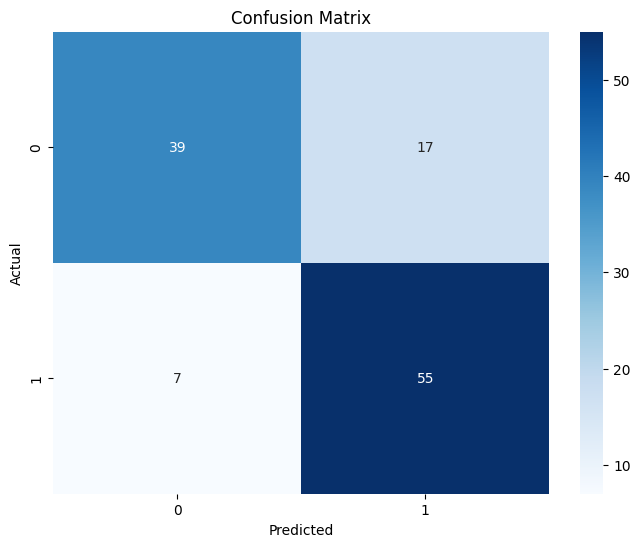

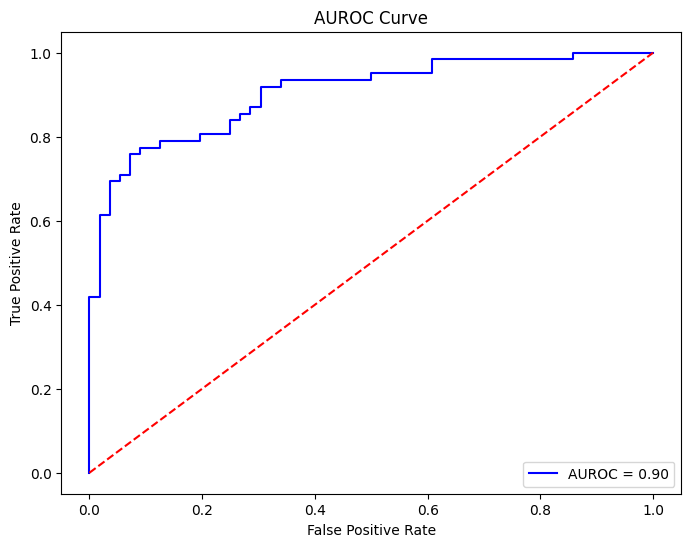

In [45]:
# Import necessary libraries
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report

# Load your dataset
data = final_df3.+
data = data.drop(columns='ID')


# Define the target and features
target = 'MASH'
features = [col for col in data.columns if col != target]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], test_size=0.2, random_state=42)

# Initialize CatBoostClassifier
model = CatBoostClassifier(iterations=1000, 
                           learning_rate=0.1, 
                           depth=6, 
                           loss_function='Logloss', 
                           verbose=200)

# Train the model
model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
auroc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

# Print accuracy and classification report
print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plot AUROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUROC = {auroc:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUROC Curve')
plt.legend(loc='lower right')
plt.show()


Finding top 10 features

Lightgbm

In [46]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score

# Load data
data = featuredf_60
X = data.drop('MASH', axis=1) 
y = data['MASH']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Initialize LightGBM classifier
lgbm = lgb.LGBMClassifier()

# Initialize RFE with LightGBM
rfe = RFE(estimator=lgbm, n_features_to_select=10, step=1)

# Train RFE with LightGBM
rfe.fit(X_train, y_train)

# Get the ranking of features
ranking = rfe.ranking_

# Evaluate the model
y_pred = rfe.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy with selected features: {accuracy}")

# Selected features
lightgbm_selected_10_features = [feature for feature, rank in zip(X.columns, ranking) if rank == 1]
print(f"Selected features: {lightgbm_selected_10_features}")


[LightGBM] [Info] Number of positive: 238, number of negative: 172
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6426
[LightGBM] [Info] Number of data points in the train set: 410, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.580488 -> initscore=0.324776
[LightGBM] [Info] Start training from score 0.324776
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

CatBoost

In [47]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score

# Load data
data = featuredf_60
X = data.drop('MASH', axis=1) 
y = data['MASH']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Initialize CatBoost classifier
catboost = CatBoostClassifier(iterations=100, depth=6, learning_rate=0.1, loss_function='Logloss', verbose=0)

# Initialize RFE with CatBoost
rfe = RFE(estimator=catboost, n_features_to_select=10, step=1)

# Train RFE with CatBoost
rfe.fit(X_train, y_train)

# Get the ranking of features
ranking = rfe.ranking_

# Evaluate the model
y_pred = rfe.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy with selected features: {accuracy}")

# Selected features
catboost_selected_10features = [feature for feature, rank in zip(X.columns, ranking) if rank == 1]
print(f"Selected features: {catboost_selected_10features}")


Model accuracy with selected features: 0.7045454545454546
Selected features: ['119.06855_53.2', '518.3686_26.5', '201.04415_88.3', '212.05745_62.05', '254.0925_89.9', '265.154_28.25', '357.981_52.6', '456.06815_78.45', '506.6724_54', '646.0214_23.8']


In [48]:
ffeatur10ecsv=pd.DataFrame()
ffeatur10ecsv['LightGBM features'] = lightgbm_selected_10_features
ffeatur10ecsv['CatBoost features'] = catboost_selected_10features

In [49]:
ffeatur10ecsv.to_csv('C:/Users/shrra/Downloads/MASH_ML/Top10features.csv', index=False)

Final 10 sel + Clinical

In [50]:
cat_10= ['ID','MASH','119.06855_53.2', '518.3686_26.5', '201.04415_88.3', '212.05745_62.05', '254.0925_89.9', '265.154_28.25', '357.981_52.6', '456.06815_78.45', '506.6724_54', '646.0214_23.8']
clin_15=['AST (U/L)', 'ALT (U/L)','GGT (U/L)','Platelet count','Female n(%)','HOMA-IR','Insulin (uU/mL)','Albumin (g/dL)','BMI z-score','TG:HDL ratio','Alk phos (U/L)','Age (yrs.)','HDL-c (mg/dL)','Creatinine (mg/dL)']

In [51]:

metab_10df= Updated_meta_df[cat_10]
clin_15_df = mash_df[clin_15]
final_df = pd.DataFrame()
final_df
final_10df = pd.concat([metab_10df,clin_15_df], axis=1)

0:	learn: 0.6590339	test: 0.6610936	best: 0.6610936 (0)	total: 2.51ms	remaining: 2.51s
200:	learn: 0.0218532	test: 0.4161290	best: 0.4023303 (57)	total: 315ms	remaining: 1.25s
400:	learn: 0.0064183	test: 0.4457160	best: 0.4023303 (57)	total: 626ms	remaining: 934ms
600:	learn: 0.0038540	test: 0.4737921	best: 0.4023303 (57)	total: 920ms	remaining: 611ms
800:	learn: 0.0031823	test: 0.4800270	best: 0.4023303 (57)	total: 1.22s	remaining: 303ms
999:	learn: 0.0028327	test: 0.4827358	best: 0.4023303 (57)	total: 1.52s	remaining: 0us

bestTest = 0.4023302672
bestIteration = 57

Shrink model to first 58 iterations.
Accuracy: 0.8389830508474576
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.75      0.82        56
           1       0.80      0.92      0.86        62

    accuracy                           0.84       118
   macro avg       0.85      0.83      0.84       118
weighted avg       0.85      0.84      0.84       118



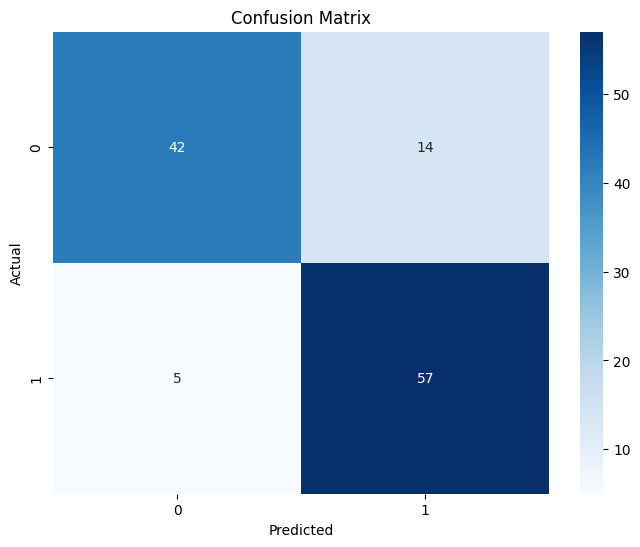

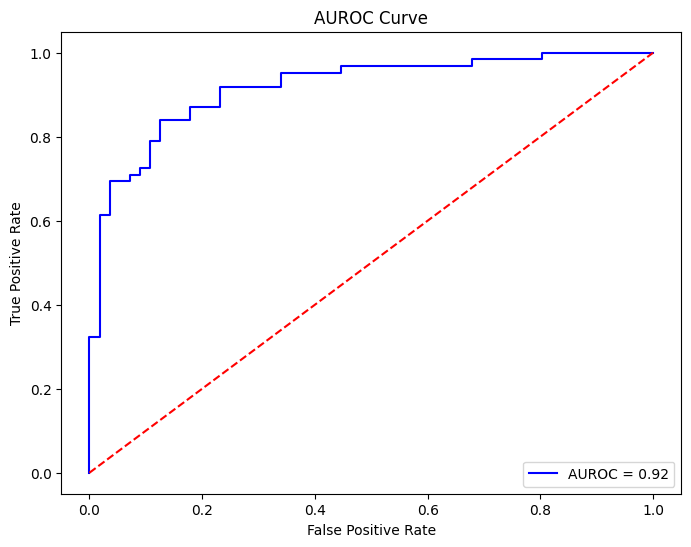

In [52]:
# Import necessary libraries
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report

# Load your dataset
data = final_10df
data = data.drop(columns='ID')


# Define the target and features
target = 'MASH'
features = [col for col in data.columns if col != target]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], test_size=0.2, random_state=42)

# Initialize CatBoostClassifier
model = CatBoostClassifier(iterations=1000, 
                           learning_rate=0.1, 
                           depth=6, 
                           loss_function='Logloss', 
                           verbose=200)

# Train the model
model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
auroc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

# Print accuracy and classification report
print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plot AUROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUROC = {auroc:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUROC Curve')
plt.legend(loc='lower right')
plt.show()
